## refs
- https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d
- https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#
- https://github.com/gboeing/2014-summer-travels/blob/master/clustering-scikitlearn.ipynb

In [1]:
import json
import time # unused?
import csv
import seaborn as sns
import numpy as np # +dep
import pandas as pd # +dep
import matplotlib.pyplot as plt # interactive notebook
#import seaborn as sns # unused?
import matplotlib as mpl
# mappings, interactive notebook
#import cartopy
import folium

In [2]:
# raw NRT data
import pathlib
#data = pd.read_csv(str(pathlib.Path("/home/jkp/Documents/agni/extras/fire.csv").resolve()))
data_y2019 = pd.read_csv(str(pathlib.Path("./hotspots_data_2019.csv").resolve()))
#data = pd.read_csv(str(pathlib.Path("/home/jkp/Documents/agni/extras/hotspots_data_2019.csv").resolve()))
#data = pd.read_csv(str(pathlib.Path("/home/jkp/Documents/agni/extras/ARIMA-train-day1.csv"...).resolve()))
#data2 = pd.read_csv(str(pathlib.Path("/home/jkp/Documents/agni/extras/ARIMA-train-day2.csv").resolve()))
filtered_data = data_y2019[data_y2019.acq_date.str.contains('2019-03')].append(data_y2019[data_y2019.acq_date.str.contains('2019-04')])
filtered_data.acq_date.unique()
data_y2019.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,type
0,14.373807,100.632462,326.08,0.34,0.56,2019-01-01,557,N,VIIRS,n,1,281.98,2.49,0
1,14.378959,100.631424,341.67,0.34,0.56,2019-01-01,557,N,VIIRS,n,1,283.59,2.49,0
2,14.624126,102.694824,334.70,0.50,0.49,2019-01-01,557,N,VIIRS,n,1,286.68,4.82,0
3,14.395066,102.168671,328.69,0.54,0.51,2019-01-01,557,N,VIIRS,n,1,288.09,4.43,0
4,14.996263,104.727219,335.78,0.55,0.43,2019-01-01,557,N,VIIRS,n,1,299.92,4.33,0


In [3]:
#april_data = pd.read_csv(str(pathlib.Path("/home/jkp/Documents/agni/extras/firem04-m05.csv").resolve()))
april_data = filtered_data
april_data.head()
unique_date = april_data.acq_date.unique()
#unique_date = ['2019-04-01','2019-04-02']
print(unique_date)

[&#39;2019-03-01&#39; &#39;2019-03-02&#39; &#39;2019-03-03&#39; &#39;2019-03-04&#39; &#39;2019-03-05&#39;
 &#39;2019-03-06&#39; &#39;2019-03-07&#39; &#39;2019-03-08&#39; &#39;2019-03-09&#39; &#39;2019-03-10&#39;
 &#39;2019-03-11&#39; &#39;2019-03-12&#39; &#39;2019-03-13&#39; &#39;2019-03-14&#39; &#39;2019-03-15&#39;
 &#39;2019-03-16&#39; &#39;2019-03-17&#39; &#39;2019-03-18&#39; &#39;2019-03-19&#39; &#39;2019-03-20&#39;
 &#39;2019-03-21&#39; &#39;2019-03-22&#39; &#39;2019-03-23&#39; &#39;2019-03-24&#39; &#39;2019-03-25&#39;
 &#39;2019-03-26&#39; &#39;2019-03-27&#39; &#39;2019-03-28&#39; &#39;2019-03-29&#39; &#39;2019-03-30&#39;
 &#39;2019-03-31&#39; &#39;2019-04-01&#39; &#39;2019-04-02&#39; &#39;2019-04-03&#39; &#39;2019-04-04&#39;
 &#39;2019-04-05&#39; &#39;2019-04-06&#39; &#39;2019-04-07&#39; &#39;2019-04-08&#39; &#39;2019-04-09&#39;
 &#39;2019-04-10&#39; &#39;2019-04-11&#39; &#39;2019-04-12&#39; &#39;2019-04-13&#39; &#39;2019-04-14&#39;
 &#39;2019-04-15&#39; &#39;2019-04-16&#39; &#3

## Fire Prediction Model V1: Simple spreading (as far as i understand):

- make a grid over region of interest for prediction
- take raw heat point, and then do spatial binning into cell of size  
  (ideally 375m, as used in VIIRS data point radius)
- depending on usage, the resulting grid either represents cell with fire, 
  or be marked as 'burned' (cannot burn any further)
- 'spread' fire to neighboring 3x3 grid if it can (cell is not mark as burned)
  - looks awfully like morphology dilate with 3x3 square kernel
- mark the old 'fire' cell as 'burned', fire won't spread there.

In [4]:
# projection setup
import utm
import pyproj

# perfome some project from latlon -> UTM 47N so I can do things in meters
# force use of x, y (lon, lat) (east, north) order
proj_latlon = pyproj.Proj('epsg:4326') # lat, lon
proj_utm47n = pyproj.Proj('epsg:32647') # UTM 47N, as appeared in shapefiles

utm47n_tf = UTM47N_TF = pyproj.Transformer.from_proj(proj_latlon, proj_utm47n, always_xy=True)
lonlat_tf = LONLAT_TF = pyproj.Transformer.from_proj(proj_utm47n, proj_latlon, always_xy=True)

In [6]:
# data setup
_DAY = '2019-03-29'
tdf = april_data.loc[april_data.acq_date == _DAY]

# set up starting point on area sampling/prediction
lat = 17.779913 
lon = 97.715363
lon_u, lat_u = utm47n_tf.transform(lon, lat)

# prepare for spatial binnings, making bin edges
step_size = 375
step_count = 100 # EDGES
lons_u = np.linspace(lon_u, lon_u + (step_size * step_count), step_count)
lats_u = np.linspace(lat_u, lat_u + (step_size * step_count), step_count)

In [7]:
def generate_firegrid(nrt_points, origin, step_size, step_count, utm=False):
    """ generate firegrid from NRT data
        also return edges used in binning
    """
    if isinstance(nrt_points, pd.DataFrame):
        nrt_df = nrt_points.copy()
    else:
        nrt_df = pd.DataFrame(nrt_points)
    # set up starting point on area sampling/prediction

    # LONGITUDE FIRST
    lat, lon = origin

    lon_u, lat_u = UTM47N_TF.transform(lon, lat)

    # prepare for spatial binnings, making bin edges
    lons_u = np.linspace(lon_u, lon_u + (step_size * step_count), step_count)
    lats_u = np.linspace(lat_u, lat_u + (step_size * step_count), step_count)

    # convert to UTM
    if not utm:
        nrt_df['longitude'], nrt_df['latitude'] = UTM47N_TF.transform(nrt_df.longitude.to_list(), nrt_df.latitude.to_list())

    # actually binning, abuse histogram2d to count
    count_u, lon_edge_u, lat_edge_u = np.histogram2d(x=nrt_df.longitude, y=nrt_df.latitude, bins=(lons_u, lats_u))
    # filter only those with values
    firegrid = (count_u.T > 0).astype(int)
    edges = (lon_edge_u, lat_edge_u)

    return firegrid, edges

(99, 99)

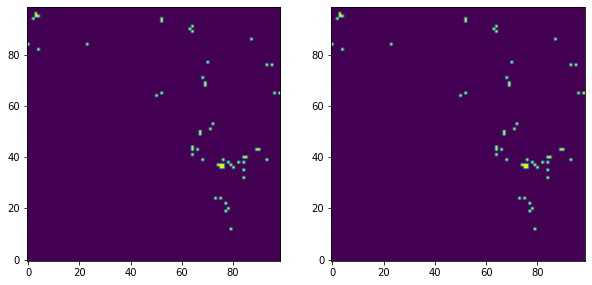

In [13]:
# try grouping to grids
# transform coordinate to UTM
tdf_u = tdf.copy()
tdf_u['longitude'], tdf_u['latitude'] = utm47n_tf.transform(tdf_u.longitude.to_list(), tdf_u.latitude.to_list())
# do the binning, abuses `np.histogram2d` to count which cell has fire for us
count_u, lon_edge_u, lat_edge_u = np.histogram2d(x=tdf_u.longitude, y=tdf_u.latitude, bins=(lons_u, lats_u))
# only need existence not count
firegrid_u = count_u.T > 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1, aspect='equal')
plt.imshow(firegrid_u, origin='lower')

plt.subplot(1, 2, 2, aspect='equal')
firegrid_f, edges = generate_firegrid(tdf, (lat, lon), 375, 100)
plt.imshow(firegrid_f, origin='lower')

display(firegrid_u.shape)

In [ ]:
# reference implementation
import math

#กำหนดค่า
pi = math.pi
r_earth = 6371000.0 #m
#กำหนดจุดแรกของ grid ที่จะวาดบนแผนที่
lat = 17.779913 
lon = 97.715363
dy2 = 375
dx2 = 375
lat_step =  (dy2 / r_earth) * (180 / pi)
lon_step =  (dx2 / r_earth) * (180 / pi) / math.cos(lat * pi/180)
step_count = 100

#แบ่ง lat lon ออกเป็น 100 ช่อง
lons = np.linspace(lon, lon+(lon_step*step_count) ,step_count)
lats = np.linspace(lat, lat+(lat_step*step_count) ,step_count)

In [ ]:
# same thing but operate on lat/lon directly
# just for testing
count, lon_edge, lat_edge = np.histogram2d(x=tdf.longitude, y=tdf.latitude, bins=(lons, lats))
firegrid = count.T > 0
plt.figure()
plt.axis('equal')
plt.imshow(firegrid, origin='lower')
plt.colorbar()
display(firegrid.shape)

In [ ]:
# check discrepancy bc i'm very confused of differing grid sizes
binedges = pd.DataFrame()
ddf_dict = {'longitude': lons, 'latitude': lats, 'longitude_u': lons_u, 'latitude_u': lats_u}
for k, v in ddf_dict.items():
    binedges[k] = pd.Series(v)

binedges['delta_lon'], binedges['delta_lat'] = lonlat_tf.transform(binedges.longitude_u.to_list(), binedges.latitude_u.to_list())
binedges['delta_lon'] -= binedges['longitude']
binedges['delta_lat'] -= binedges['latitude']

display(binedges[['delta_lon', 'delta_lat']].max())
display(binedges)

count_results\[วันที่ใน unique date\]\[แกน y\]\[แกน x\]

Ex. count_results\[0\] คือข้อมูลวันที่ unique_date\[0\] , '2019-03-01'

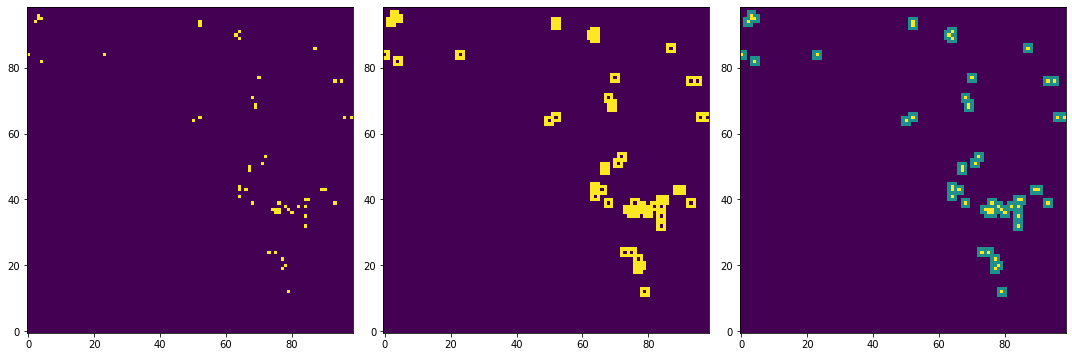

In [16]:
from scipy import ndimage
# TBD
# the 'spreading' looks awfully like morphology dilate with 3x3  kernel of ones
# with zero hole at the middle
z8_kernel = np.ones((3, 3))
z8_kernel[1,1] = 0
# generate next iteration
firegrid_u_next = ndimage.binary_dilation(firegrid_u, structure=z8_kernel, border_value=0).astype(int)

# for references only
# enum gridstates {
#   TREE = 0,
#   FIRE = 1,
#   BURNED = 2,
# }

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1, aspect='equal')
#plt.pcolormesh(lon_edge_u, lat_edge_u, firegrid_u)
plt.imshow(firegrid_u, origin='lower')
#plt.colorbar()

plt.subplot(1, 3, 2, aspect='equal')
plt.imshow(firegrid_u_next, origin='lower')
#plt.colorbar()

plt.subplot(1, 3, 3, aspect='equal')
# try to combine 2 grids together
# the 'burned' cell will not burn further
firegrid_u_comp = firegrid_u_next.copy()
firegrid_u_comp[firegrid_u] = 2
plt.imshow(firegrid_u_comp, origin='lower')

plt.tight_layout()
plt.show()

In [ ]:
#ดูว่าไฟช่องไหนไหม้ไปแล้วบ้าง firstIDX วันแรก lastIDX วันสุดท้าย
#reference grid type of this cell
L_EMPTY, L_TREE, L_FIRE = 0, 1, 2
area = count_results[32]
def markEmptyArea(data,firstIDX,lastIDX):
    empty_lands = np.ones((GRIDS,GRIDS))
    for i in range(firstIDX,lastIDX):
        print(i)
        tmp = data[i]
        for ix in range(1,nx-1):
            for iy in range(1,ny-1):
                #change old fire to empty lands
                if tmp[iy,ix] == L_FIRE:
                    empty_lands[iy,ix] = L_EMPTY
    return empty_lands
#มาร์คว่าไฟจะกระจายไปช่องไหนได้บ้าง
def markFire(lands,fire):
    for ix in range(1,nx-1):
        for iy in range(1,ny-1):
            #change old fire to empty lands
            if fire[iy,ix] == L_FIRE:
                lands[iy,ix] = L_FIRE
    return lands
#ส่งไปในฟังชันมารค์จุดที่เคยเกิดไฟ
start_date = 21
end_date = 35
markedEmpty = markEmptyArea(count_results,start_date,end_date) #count results มี 61 วันเลือกมาร์คช่องที่เกิดไฟแล้วในวันที่ 21 ถึง 35
#กระจายไฟออกรอบๆ
markedFire = markFire(markedEmpty,count_results[35])

In [ ]:
#กระจายไฟที่อาจจะมีในวัดถัดไป
nextDayFire = iterate(markedFire)

In [ ]:
import pyproj
import math
CELLTYPE = ['EMPTY', 'TREE', 'FIRE']
GRIDS=100
#source https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters
#กำหนดจุดศูนย์กลางของ grid แรก
lat = 17.779913 
lon =  97.715363

pi = math.pi
r_earth = 6371000.0 #m
lmap = folium.Map(location=[lat, lon], zoom_start=15)
dy2 = 350/2
dx2 = 350/2
step_lat =  (dy2 / r_earth) * (180 / pi)
step_lon =  (dx2 / r_earth) * (180 / pi) / math.cos(lat * pi/180)

#more grid
target = nextDayFire
start_lon = lon
curr_lat = lat
curr_lon  = start_lon
draw_b1=0
#to influx
predict_points = []


for ix in range(0,GRIDS):
    draw_b2 = 0
    for iy in range(0,GRIDS):
        points = [(curr_lat-step_lat,curr_lon-step_lon),(curr_lat+step_lat,curr_lon+step_lon)]
        #save data
        if target[ix,iy] != TREE:
            save_dict = {
                    'latitude' : lat + step_lat*2*ix,
                    'longitude' : lon + step_lon*2*iy,
                    'base_date' : unique_date[end_date],
                    'type': CELLTYPE[int(target[ix,iy])]
            }
            predict_points.append(save_dict)
          
    draw_b1+=1
    curr_lat += step_lat*2
    curr_lon = start_lon

#plot data
data = data_y2019[data_y2019.acq_date.str.contains('2019-04-06')]
for _, row in data.iterrows():
    folium.CircleMarker(location=(row['latitude'], row['longitude']),
                        radius=6, fill_color='red', fill_opacity=1,
                        popup="<b>lat</b>: {} <b>lon</b>: {}".format(row['latitude'],row['longitude'])
                        ).add_to(lmap)
    points = [(row['latitude']-step_lat,row['longitude']-step_lon),(row['latitude']+step_lat,row['longitude']+step_lon)]
    #folium.Rectangle(bounds=points,fill=False,color = 'red',weight=1).add_to(lmap)
lmap

In [ ]:
target = nextDayFire
start_lon = lon
curr_lat = lat
curr_lon  = start_lon
draw_b1=0
for ix in range(0,GRIDS):
    draw_b2 = 0
    for iy in range(0,GRIDS):
        points = [(curr_lat-step_lat,curr_lon-step_lon),(curr_lat+step_lat,curr_lon+step_lon)]
        if target[ix,iy] == FIRE:
            print('Fire',ix,iy)
        elif target[ix,iy] == TREE:
            opa = 0.5
            #folium.Rectangle(bounds=points,fill=True,color = 'black',fill_color = 'green',fill_opacity=opa,weight=1).add_to(lmap)
        
        draw_b2+=1
        curr_lon += step_lon*2
        
    draw_b1+=1
    curr_lat += step_lat*2
    curr_lon = start_lon

In [ ]:
unique_date[end_date]

In [ ]:
#source https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters
lat = 17.779913 
lon = 97.715363

pi = math.pi
r_earth = 6371000.0 #m
lmap = folium.Map(location=[lat, lon], zoom_start=15)
dy2 = 350/2
dx2 = 350/2
step_lat =  (dy2 / r_earth) * (180 / pi)
step_lon =  (dx2 / r_earth) * (180 / pi) / math.cos(lat * pi/180)

#draw one grid
points = [(lat-step_lat,lon-step_lon),(lat+step_lat,lon+step_lon)]
folium.Rectangle(bounds=points,fill=True,color = 'red',fill_color = '#940091',fill_opacity=0,weight=1).add_to(lmap)

#more grid
target = test
start_lon = lon
curr_lat = lat
curr_lon  = start_lon
draw_b1=0
GRIDS=100
EMPTY, TREE, FIRE = 0, 1, 2
for ix in range(0,GRIDS):
    draw_b2 = 0
    for iy in range(0,GRIDS):
        points = [(curr_lat-step_lat,curr_lon-step_lon),(curr_lat+step_lat,curr_lon+step_lon)]
        if target[ix,iy] == FIRE:
            opa = 1
            folium.Rectangle(bounds=points,fill=True,color = 'black',fill_color = 'red',fill_opacity=opa,weight=1).add_to(lmap)
        elif target[ix,iy] == TREE:
            opa = 0.5
            folium.Rectangle(bounds=points,fill=True,color = 'black',fill_color = 'green',fill_opacity=opa,weight=1).add_to(lmap)
        
        draw_b2+=1
        curr_lon += step_lon*2
        
    draw_b1+=1
    curr_lat += step_lat*2
    curr_lon = start_lon

#plot data
data = data_y2019[data_y2019.acq_date.str.contains('2019-03-30')]
for _, row in data.iterrows():
    folium.CircleMarker(location=(row['latitude'], row['longitude']),
                        radius=6, fill_color='red', fill_opacity=1,
                        popup="<b>lat</b>: {} <b>lon</b>: {}".format(row['latitude'],row['longitude'])
                        ).add_to(lmap)
    points = [(row['latitude']-step_lat,row['longitude']-step_lon),(row['latitude']+step_lat,row['longitude']+step_lon)]
    #folium.Rectangle(bounds=points,fill=False,color = 'red',weight=1).add_to(lmap)
lmap

In [ ]:
def iterate(X):
    """Iterate the forest according to the forest-fire rules."""
    # The boundary of the forest is always empty, so only consider cells
    # indexed from 1 to nx-2, 1 to ny-2
    EMPTY, TREE, FIRE = 0, 1, 2
    neighbourhood = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
    nx, ny = 100, 100
    
    X1 = np.zeros((ny, nx))
    for ix in range(1,nx-1):
        for iy in range(1,ny-1):
            if X[iy,ix] == FIRE:
                X1[iy,ix] = EMPTY
            if X[iy,ix] == TREE:
                X1[iy,ix] = TREE
                for dx,dy in neighbourhood:
                    if X[iy+dy,ix+dx] == FIRE:
                        X1[iy,ix] = FIRE
                        break
    return X1

def forecastFire(old_hotspots,today_hotspots): #old_hotspots is hotspots each day in array [day1,day2,day3,...]
    hotspot_grid = []
    GRIDS = 101
    lands = np.ones((GRIDS,GRIDS))
    #loop to mark old hotspots as empty lands
    for day in old_hotspots:
        read_data = day
        #loop each data row
        for i,r in read_data.iterrows():
            #loop data grid
            for b1 in range(GRIDS):
                if lats[b1] - (lat_step/2) <= r['latitude'] < lats[b1] + (lat_step/2):
                    for b2 in range(GRIDS):
                        if lons[b2] - (lon_step/2 ) <= r['longitude'] < lons[b2] + (lon_step/2):
                            lands[b1,b2] = 0 # marks as empty land
                            #hotspots_counts[b1,b2] += 1
    #loop to mark today hotspots as fire
    for i,r in today_hotspots.iterrows():
            #loop data grid
            for b1 in range(GRIDS):
                if lats[b1] - (lat_step/2) <= r['latitude'] < lats[b1] + (lat_step/2):
                    for b2 in range(GRIDS):
                        if lons[b2] - (lon_step/2 ) <= r['longitude'] < lons[b2] + (lon_step/2):
                            lands[b1,b2] = 2 # marks as empty fire
    #append nearby fire risk
    predict_fire = iterate(lands)
    return predict_fire #101x101 array
#test data
day1 = april_data[april_data.acq_date.eq('2019-03-30')]
day2 = april_data[april_data.acq_date.eq('2019-03-31')]
day3 = april_data[april_data.acq_date.eq('2019-04-01')]
test_old_data = [day1,day2,day3]
test_today_data = april_data[april_data.acq_date.eq('2019-04-02')]
#run
test = forecastFire(test_old_data,test_today_data)

In [ ]:
len(test)

In [ ]:
unique_date[30]

In [ ]:
def toDictOnlyFIREandEMPTY(dataGrid,date): #(101x101 array, date of data)
    CELLTYPE = ['EMPTY', 'TREE', 'FIRE']
    EMPTY, TREE, FIRE = 0, 1, 2
    pi = math.pi
    r_earth = 6371000.0 #m
    #start lat lon of grid (bottom left)
    lat = 17.779913 
    lon =  97.715363
    #grid distance
    dy2 = 350/2
    dx2 = 350/2
    step_lat =  (dy2 / r_earth) * (180 / pi)
    step_lon =  (dx2 / r_earth) * (180 / pi) / math.cos(lat * pi/180)
    #
    target = dataGrid
    start_lon = lon
    curr_lat = lat
    curr_lon  = start_lon
    draw_b1=0
    #to influx
    predict_points = []
    for ix in range(0,GRIDS):
        draw_b2 = 0
        for iy in range(0,GRIDS):
            points = [(curr_lat-step_lat,curr_lon-step_lon),(curr_lat+step_lat,curr_lon+step_lon)]
            #save data
            if target[ix,iy] != TREE:
                save_dict = {
                        'latitude' : lat + step_lat*2*ix,
                        'longitude' : lon + step_lon*2*iy,
                        'base_date' : date,
                        'type': CELLTYPE[int(target[ix,iy])]
                }
                predict_points.append(save_dict)

        draw_b1+=1
        curr_lat += step_lat*2
        curr_lon = start_lon
    return predict_points #python dict only FIRE and EMPTY
test_date = '2019-04-02'
python_dict = toDictOnlyFIREandEMPTY(test,test_date)